**Перейдем к обучению сверточной нейронной сети (CNN).** Сверточные сети хорошо подходят для временных рядов, так как сверточные слои могут выделять важные временные характеристики из данных.  
**Импорт Библиотек:** Импортируем не только стандартные библиотеки для работы с данными, но и библиотеки для работы с нейронными сетями, такие как Keras.

**Предобработка Данных:** Подготовим данные к обучению CNN, что включает в себя масштабирование и преобразованию данных для подачи в сверточную нейронную сеть (CNN).  

**Создание Модели LSTM:** Определим архитектуру CNN с необходимым количеством слоёв и нейронов.

**Обучение Модели:** Обучим модель на тренировочных данных.

**Оценка Модели:** Оценим производительность модели на валидационных данных.

**Предсказания и Сохранение Результата:** Используем модель для предсказания тестовых данных и сохраним результаты.


In [ ]:
from tensorflow import keras

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [ ]:
# Подключим google disk на который загружены данные эксперимента /Colab Notebooks/mat_data/Z_EEG_1/
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Загрузка данных
data_path = '/content/gdrive/MyDrive/Colab Notebooks/mat_data/Z_EEG_1/train/subj1_series1_data.csv'
events_path = '/content/gdrive/MyDrive/Colab Notebooks/mat_data/Z_EEG_1/train/subj1_series1_events.csv'
test_data_path = '/content/gdrive/MyDrive/Colab Notebooks/mat_data/Z_EEG_1/test/subj1_series9_data.csv'

# Чтение данных
data = pd.read_csv(data_path)
events = pd.read_csv(events_path)
test_data = pd.read_csv(test_data_path)

In [ ]:
# Определение функции для создания последовательностей
def create_sequences(data, labels, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        if labels is not None:
            y.append(labels[i + window_size])
    return np.array(X), (np.array(y) if labels is not None else None)

# Масштабирование данных
scaler = StandardScaler()
# Тренировочные данные без столбца id
data_scaled = scaler.fit_transform(data.iloc[:, 1:])
# Тестовые данные без столбца id
test_data_scaled = scaler.transform(test_data.iloc[:, 1:])

# Формирование последовательностей для тренировочного набора
window_size = 10  # Предварительно установим размер окна равное 10
X_train_seq, y_train_seq = create_sequences(data_scaled, events.iloc[:, 1:].values, window_size)
# Формирование последовательностей для тестового набора
X_test_seq, _ = create_sequences(test_data_scaled, None, window_size)

# Размерности тренировочного и тестового наборов данных должны соответствовать ожидаемому входу CNN
# Необходимо добавить дополнительное измерение, чтобы представить каналы входных данных (как в изображениях)
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2], 1))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2], 1))

# Разделение на тренировочный и валидационный наборы
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, random_state=42
)

# Проверка размерностей
print("Размеры тренировочного набора последовательностей:", X_train_seq.shape, y_train_seq.shape)
print("Размеры валидационного набора последовательностей:", X_val_seq.shape, y_val_seq.shape)
print("Размерность X_test_seq:", X_test_seq.shape)

Размеры тренировочного набора последовательностей: (95588, 10, 32, 1) (95588, 6)
Размеры валидационного набора последовательностей: (23898, 10, 32, 1) (23898, 6)
Размерность X_test_seq: (115943, 10, 32, 1)


In [ ]:
# Создание модели
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.65))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(y_train_seq.shape[1], activation='sigmoid'))

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Посмотрим на структуру модели
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             6208      
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 64)             12352     
                                                                 
 dropout (Dropout)           (None, 6, 64)             0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 3, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 100)               19300     
                                                        

In [ ]:
# Задаем параметры обучения
epochs = 20  # Количество эпох
batch_size = 32  # Размер пакета

# Обучение модели
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq)
)


Epoch 1/20
2988/2988 [==============================] - 18s 6ms/step - loss: 0.1231 - accuracy: 0.3868 - val_loss: 0.0952 - val_accuracy: 0.4392
Epoch 2/20
2988/2988 [==============================] - 18s 6ms/step - loss: 0.0854 - accuracy: 0.4291 - val_loss: 0.0766 - val_accuracy: 0.4166
Epoch 3/20
2988/2988 [==============================] - 16s 5ms/step - loss: 0.0725 - accuracy: 0.4378 - val_loss: 0.0650 - val_accuracy: 0.4608
Epoch 4/20
2988/2988 [==============================] - 16s 5ms/step - loss: 0.0658 - accuracy: 0.4418 - val_loss: 0.0608 - val_accuracy: 0.4698
Epoch 5/20
2988/2988 [==============================] - 15s 5ms/step - loss: 0.0604 - accuracy: 0.4444 - val_loss: 0.0569 - val_accuracy: 0.4544
Epoch 6/20
2988/2988 [==============================] - 16s 5ms/step - loss: 0.0567 - accuracy: 0.4583 - val_loss: 0.0527 - val_accuracy: 0.4561
Epoch 7/20
2988/2988 [==============================] - 15s 5ms/step - loss: 0.0534 - accuracy: 0.4621 - val_loss: 0.0473 - val_ac

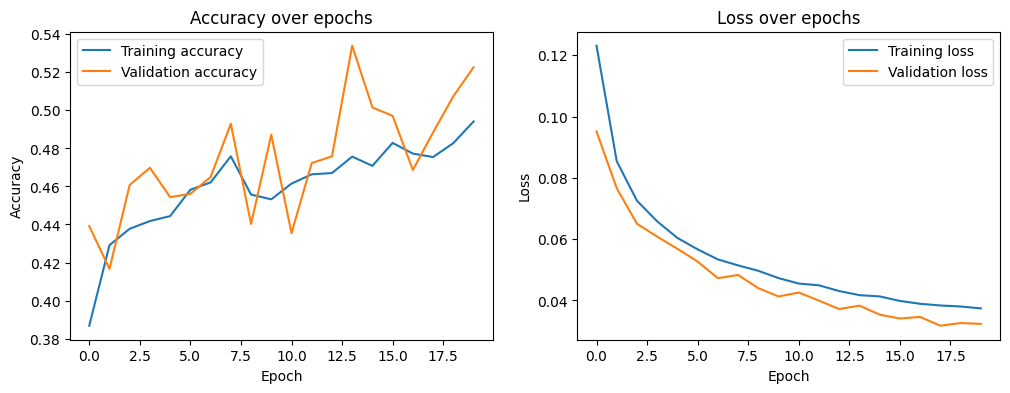

In [ ]:
# Визуализация процесса обучения
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


Из результатов обучения видно, что модель демонстрирует улучшение по сравнению с предыдущими моделями. Функция потерь на валидационном наборе данных снижается, что указывает на то, что модель обучается. Тем не менее, точность на валидационном наборе все еще довольно низкая, и график точности показывает заметные колебания, что может свидетельствовать о том, что модель все еще не полностью улавливает закономерности в данных или сталкивается с проблемой переобучения.  

Возможны следующие шаги для улучшения производительность модели:  

**Уменьшение сложности модели:** Если есть переобучение, уменьшение сложности модели может помочь. Это может включать в себя уменьшение количества нейронов в слоях или уменьшение количества слоев.  

**Использование техник регуляризации:** Помимо L2-регуляризации и слоев Dropout, которые уже используются, можно применять и другие методы, такие как увеличение коэффициента Dropout или использование Early Stopping во время обучения, чтобы предотвратить переобучение.  

**Изменение стратегии обучения:** Это может включать изменение скорости обучения, использование адаптивной скорости обучения или изменение оптимизатора.  

**Увеличение объема данных:** Если это возможно, увеличение количества тренировочных данных или использование методов аугментации данных может помочь улучшить способность модели к обобщению.  

**Подстройка порога:** Как и в случае с предыдущей моделью LSTM, подстройка порога, используемого для преобразования выходных данных модели в бинарные классы, может помочь улучшить производительность.  

747/747 [==============================] - 3s 4ms/step


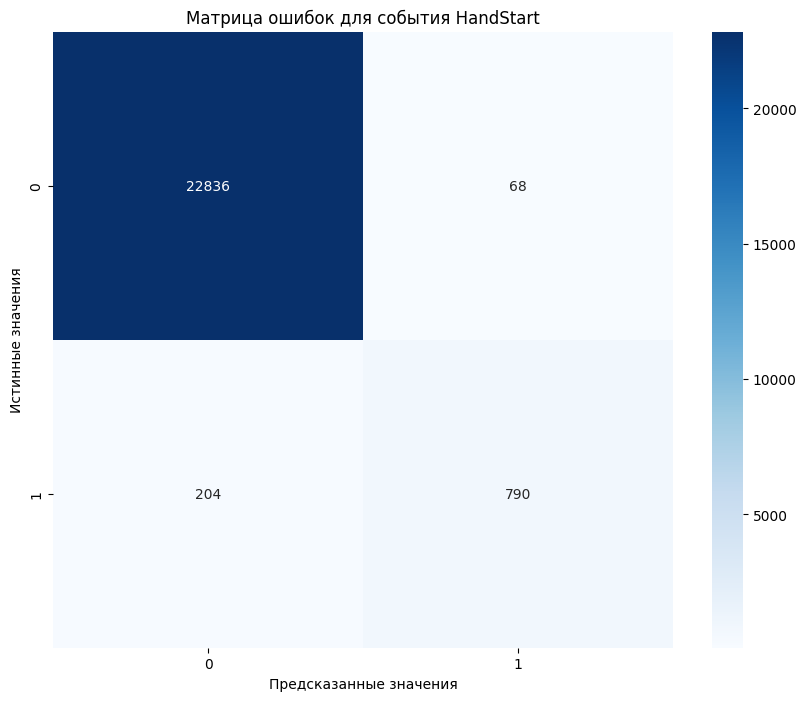

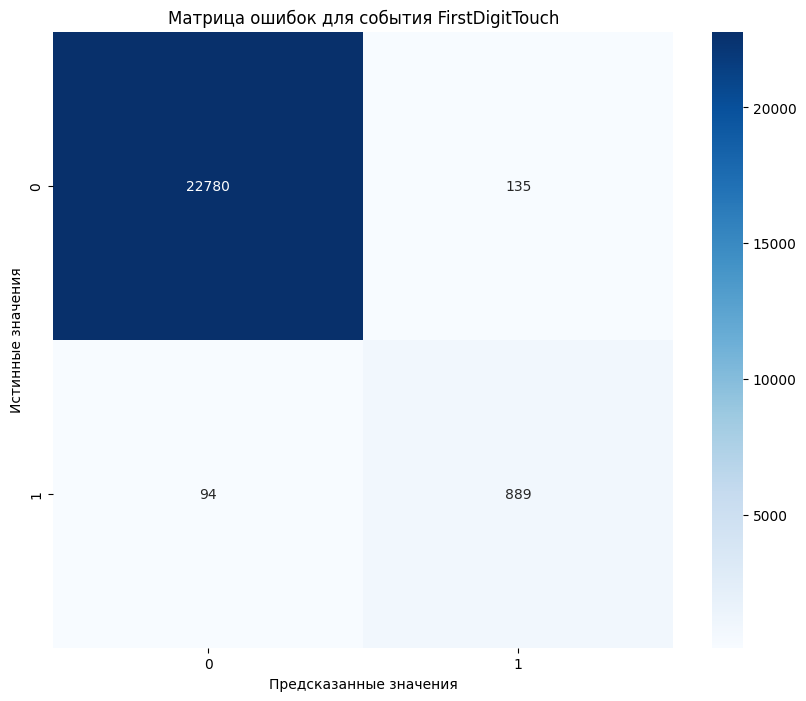

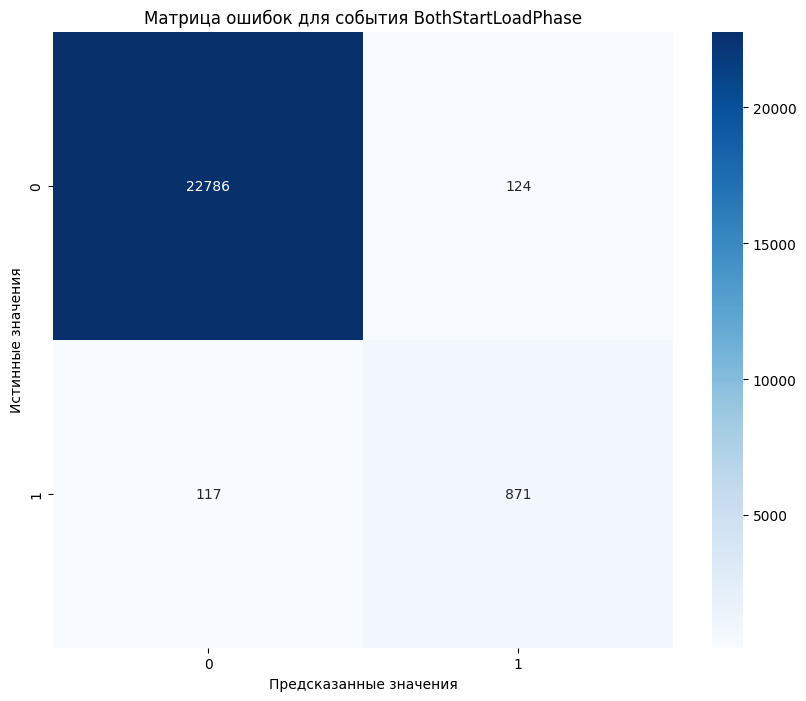

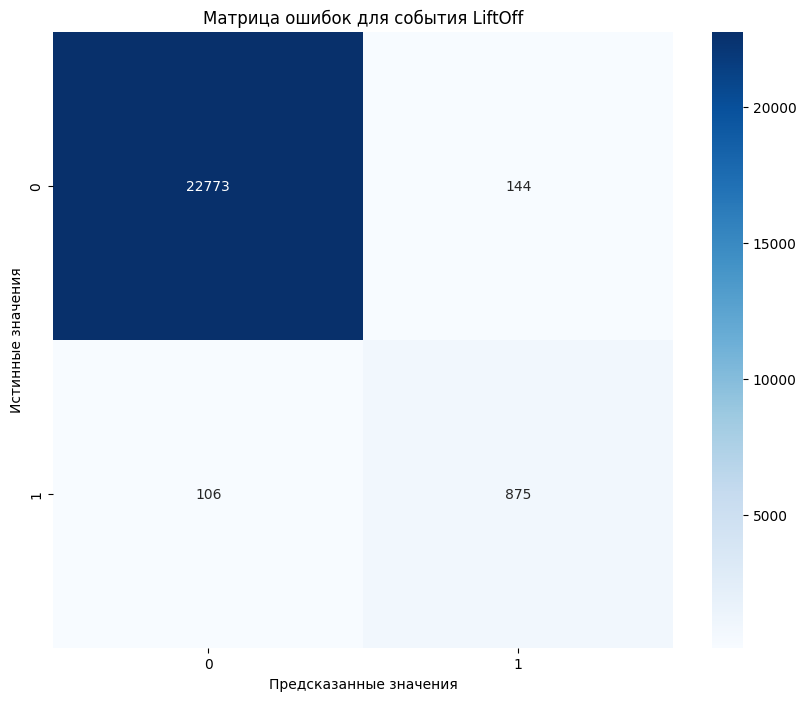

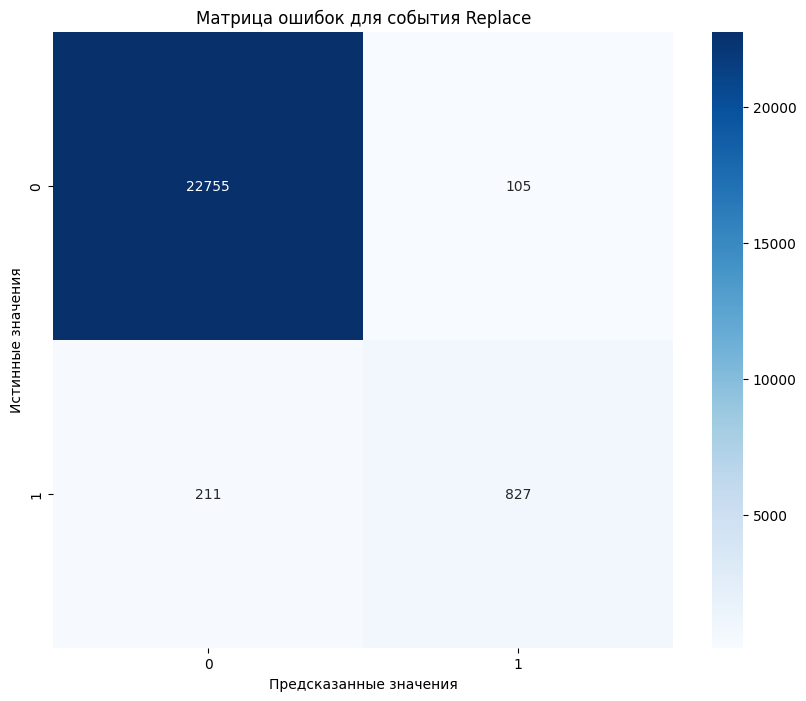

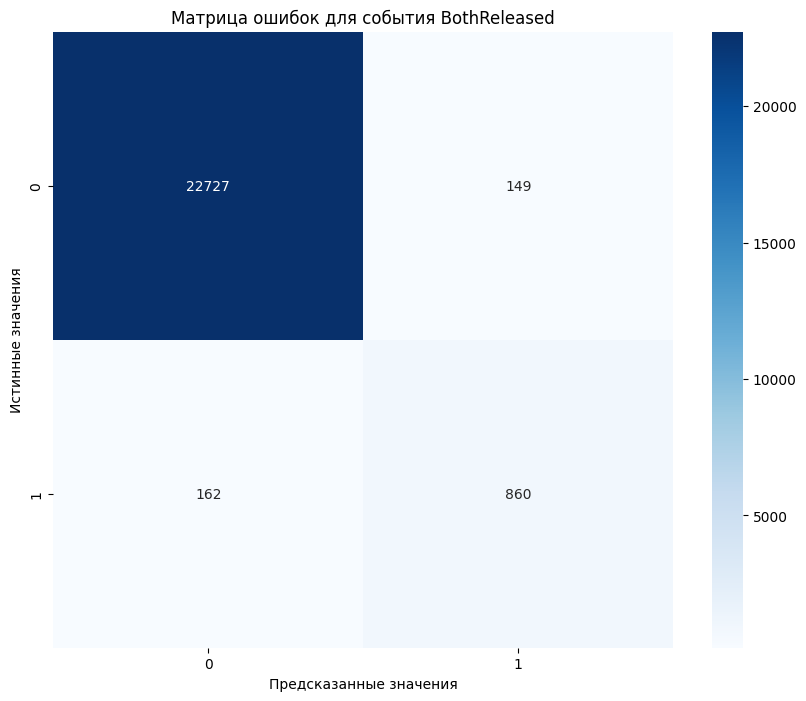

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Выполнение предсказаний на валидационном наборе данных
y_val_pred = model.predict(X_val_seq)

# Применение порога для преобразования вероятностей в метки классов
threshold = 0.5  # Можно настроить порог на основе предыдущего анализа
y_val_pred_binary = (y_val_pred > threshold).astype(int)

# Вычисление и визуализация матрицы ошибок для каждого события
for i, column in enumerate(events.columns[1:]):
    # Вычисление матрицы ошибок
    cm = confusion_matrix(y_val_seq[:, i], y_val_pred_binary[:, i])

    # Визуализация матрицы ошибок
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок для события {column}')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()


Исходя из матриц ошибок, мы видим, что модель имеет тенденцию к высокому количеству ложноположительных результатов (тип II ошибка) для некоторых событий, что указывает на то, что она слишком часто предсказывает наличие события, когда его на самом деле нет. Это может быть связано с несбалансированностью классов, когда одни события происходят гораздо реже других, и модель научилась предсказывать наиболее частые классы.  

**Чтобы улучшить модель, можно рассмотреть следующие шаги:**  

**Перебалансировка классов:** Использование техники взвешивание классов в функции потерь или аугментация данных для классов с меньшей частотой событий.  

**Изменение порога:** Настройка порога, используемого для преобразования выходных данных модели в бинарные классы, может помочь уменьшить количество ложноположительных результатов.  

**Оптимизация параметров:** Настройка гиперпараметров модели, включая скорость обучения, размеры фильтров и количество нейронов, может помочь улучшить ее способность к обобщению.  

**Добавление регуляризации:** Увеличение степени регуляризации может помочь уменьшить переобучение и улучшить способность модели к обобщению на невидимых данных.  

**Использование сложных метрик:** В дополнение к матрице ошибок, использование сложных метрик, таких как F1-мера, может дать более полное представление о производительности модели в условиях несбалансированности классов.

In [ ]:
# Предсказание на тестовом наборе данных
y_test_pred_probs = model.predict(X_test_seq)

# Применяем порог для получения явных меток классов
y_test_pred = (y_test_pred_probs > threshold).astype(int)

# Создание DataFrame для предсказаний
predicted_events_df = pd.DataFrame(y_test_pred, columns=events.columns[1:])

# Подготовка данных 'id' для тестового набора данных
# Здесь предполагается, что у вас есть соответствующий столбец 'id' в исходных данных.
test_ids = test_data['id'][window_size:].reset_index(drop=True)

# Добавление 'id' к предсказаниям
predicted_events_df.insert(0, 'id', test_ids)

# Сохранение предсказаний в CSV-файл
output_path = '/content/gdrive/MyDrive/Colab Notebooks/mat_data/Z_EEG_1/CNN/subj_series9_events.csv'
predicted_events_df.to_csv(output_path, index=False)

print(f"Файл событий сохранен как '{output_path}'.")


3624/3624 [==============================] - 7s 2ms/step
Файл событий сохранен как '/content/gdrive/MyDrive/Colab Notebooks/mat_data/Z_EEG_1/CNN/subj_series9_events.csv'.
